# Project: Investigate "The Movie Database"
(This project can also be found on [github](https://github.com/QuantificAid/tmdb_movie_data))

## Table of Contents
<ul>
<li><a href="#summary">Summary</a></li>
<li><a href="#background">Background</a></li>
<li><a href="#wrangling_eda">Data Wrangling and Exploratory Analysis</a></li>
<li><a href="#analysis">Analysis of Initial Questions</a></li>
</ul>

<a id='summary'></a>
## Summary
- In course of Udacity's "Data Analyst Nanodegree", I investigated a movie dataset from "The Movie Database".
- The dataset included approx. 10,000 movies with information about e.g. artists involved, votings/ratings, revenue, release date etc.
- I was especially interested in how ratings relate
 1. to financials
 2. to parties involved and content (as expressed by genre, keywords)
- I found that
 1. there is a correlation of movie ratings to financials, but it is only weak. You can have a lot of budget and create a miserable movie, and you can make an excellent film, but lose money.
 2. there is a stronger correlation of movie ratings to the quality of its "ingredients". This seems intuitive, however, the results must be handled with care, as the "quality of the ingredient" was calculated using the `vote_average` and so - although thoughtfully executed - the is a feedback loop causing some part of the correlation.

<a id='background'></a>
## Background

Whilst doing Udacity's "Data Analyst Nanodegree", I had to absolve an investigation of a dataset of my choice from a list of recommendations. 
I choosed a dataset from ["The Movie Database"](https://www.themoviedb.org/), which - in slight adaptation - is also published on [kaggle](http://www.kaggle.com).  

The dataset contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

- Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) characters.
- There are some odd characters in the ‘cast’ column. Don’t worry about cleaning them. You can leave them as is.
- The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.  

So let's get started:

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

I also load the dataset here, as this allows better for discussion of choices for further analysis:

In [2]:
# Import dataset

tmdb = pd.read_csv('./data/tmdb-movies.csv', encoding='raw_unicode_escape')

In order to obtain an comprehensive overview, I created a function mixing the "best of" pandas's build-in functions: 

In [3]:
def create_overview(df):
    # Function to create an aggregates overview from existing pandas methods for reuse
    # Use 'describe' and flip it for better readability
    overview = df.describe(include='all').T
    # Integrate dtypes
    overview['dtype'] = df.dtypes
    # Integrate an example (1st row)
    overview['example'] = df.head(1).T
    # % of items compared to dataset
    overview['complete_%'] = 100 * overview['count'] / df.shape[0]
    # Rename median
    overview.rename(index=str, columns={'50%': 'median'}, inplace=True)
    # Create new features (that, in 'describe', are normally only included with object columns)
    overview['top_alt'] = ''
    overview['freq_alt'] = 0
    overview['unique_alt'] = 0
    # Calculate new features
    for col in df.columns:
        value_counts = df[col].value_counts()
        overview.loc[col, 'top_alt'] = str(value_counts.index[0])
        overview.loc[col, 'freq_alt'] = value_counts.iloc[0]
        overview.loc[col, 'unique_alt'] = df[col].drop_duplicates().count()
    # Reorganize the overview (whilst neglecting some columns from 'describe')
    overview = overview[[
        # Example and dtype
        'example', 'dtype',
        # Number of items
        'count', 'complete_%', 'unique_alt',
        # Info about most frequent item
        'top_alt', 'freq_alt',
        # Some statistics
        'mean', 'std', 'min', 'median', 'max'
        ]]
    return overview

create_overview(tmdb)

,example,dtype,count,complete_%,unique_alt,top_alt,freq_alt,mean,std,min,median,max
id,135397,int64,10866,100,10865,42194,2,66064.2,92130.1,5,20669,417859
imdb_id,tt0369610,object,10856,99.908,10855,tt0411951,2,NaN,NaN,NaN,NaN,NaN
popularity,32.9858,float64,10866,100,10814,0.109305,2,0.646441,1.00018,6.5e-05,0.383856,32.9858
budget,150000000,int64,10866,100,557,0,5696,1.46257e+07,3.09132e+07,0,0,4.25e+08
revenue,1513528810,int64,10866,100,4702,0,6016,3.98233e+07,1.17003e+08,0,0,2.78151e+09
original_title,Jurassic World,object,10866,100,10571,Hamlet,4,NaN,NaN,NaN,NaN,NaN
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,object,10790,99.3006,10719,Louis C.K.,6,NaN,NaN,NaN,NaN,NaN
homepage,http://www.jurassicworld.com/,object,2936,27.0201,2896,http://www.thehungergames.movie/,4,NaN,NaN,NaN,NaN,NaN
director,Colin Trevorrow,object,10822,99.5951,5067,Woody Allen,45,NaN,NaN,NaN,NaN,NaN
tagline,The park is open.,object,8042,74.0107,7997,Based on a true story.,5,NaN,NaN,NaN,NaN,NaN


Probably, this database has one duplicate row (max `count` = max `unique_alt` + 1 = 10.865).

However, before we dig a little deeper into the various features, it's useful to define the main purpose of the following analysis. This allows to focus on the features (hopefully) more relevant to this purpose.  

There are two aspects, we analyze this dataset here, whilst **focussing on "goodness" in terms of `'vote_average'`**
- How do "good movies" perform "economically"?
- What are the artistic "ingredients" of a "good movie"? E.g., are genres and artists important to "goodness"?

There may be many more questions, even more interesting ones and there may be more sophisticated methods to analyse the dataset. However, I focussed on practicing tools from the course. Furthermore, it must be stated, that all analysis included is preliminary.
  
Now, let's describe the fields, decide if they are being kept for the purposes of this special analysis, and describe, which issues are to be handled with in the data cleaning:  


| Field | Understanding & Assumptions | Keeper? | Issues |  
|:--- |:---|:---:|:---|  
| `'id'`  | Serves as an identifier | Yes | Convert to `str`, otherwise probably none |  
| `'imdb_id'` | Serves as an identifier | **No** | We take `'id'` instead | 
| `'popularity'` | Popularity rating for TMDB's website purposes (s. [here](https://developers.themoviedb.org/3/getting-started/popularity)) | **No** | Neglecting this feature | 
| `'budget'` | Film's budget in USD | *Maybe* | No, if `budget_adj` is calculated reasonably; Be aware of `0` values | 
| `'revenue'` | Film's revenue in USD | *Maybe* | No, if `revenue_adj` is calculated reasonably; Be aware of `0` values | 
| `'original_title'` | Film title | Yes | Be aware of duplicates | 
| `'cast'` | Name of actors | Yes | Multiple items in a field and missing values | 
| `'homepage'` | Url | **No** | Neglecting this feature | 
| `'director'` | Name of director | Yes | Missing values | 
| `'tagline'` | Short description of film | **No** | Neglecting this feature, using `keywords` instead | 
| `'keywords'` | Tags for film description | Yes | Multiple items in a field and missing values | 
| `'overview'` | Longer description of film | **No** | Neglecting this feature, using `keywords` instead | 
| `'runtime'` | Runtime in minutes | Yes | Beware of `0` values | 
| `'genres'` | Tags for genre of film | Yes | Multiple items in a field and missing values | 
| `'production_companies'` | Name of production companies | Yes | Multiple items in a field and missing values | 
| `'release_date'` | Date of film release | Yes | to be transformed into `datetime` | 
| `'vote_count'` | Number of votes | Yes | Probably none | 
| `'vote_average'` | Average of votes | Yes | Probably none | 
| `'release_year'` | Year of film release | **No** | We take `'release_date'` instead| 
| `'budget_adj'` | Film's budget in USD (in 2018 prices) | Yes | Be aware of `0` values | 
| `'revenue_adj'` | Film's revenue in USD (in 2018 prices) | Yes | Be aware of `0` values | 

An indeed, there are some encoding issues in the strings, I wasn't able to fix.

<a id='wrangling_eda'></a>
## Data Wrangling And Exploratory Analysis

As I already loaded the data and created an overview of the features, now I jump right into cleaning (and some analysis useful for doing so...) 

Let's have a first look at the `vote_average`:

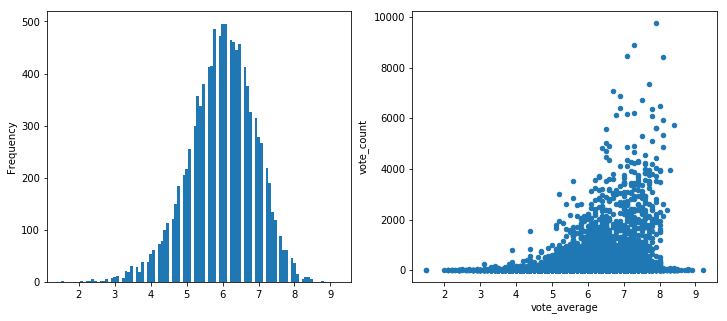

In [4]:
# First glance on 'vote_average' (and 'vote_count')

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5))
tmdb.vote_average.plot.hist(bins=100, ax=ax1)
tmdb.plot.scatter(x='vote_average', y='vote_count', ax=ax2)
plt.show()

The `vote_Average` has some strange artefacts, however its bell-shaped distribution look reasonable.

Now, we follow the thing to repair ('Issues' in table above):

In [5]:
# Turning 'release_date' into 'datetime'

date = tmdb.release_date.str.split('/', expand=True)
day = date[1].astype(int)
month = date[0].astype(int)
year = tmdb.release_year
tmdb.release_date = pd.to_datetime((year*10000+month*100+day).apply(str), infer_datetime_format=True)

del date, day, month, year

In [6]:
# Turning id into (immutable) 'string'

tmdb.id = tmdb.id.astype(str)

In [7]:
# Dropping duplicates and neglected features (in a new table)

stmdb = tmdb.drop_duplicates().copy()
stmdb.drop(axis=1, columns=['imdb_id', 'popularity', 'homepage', 'tagline', 'overview', 'release_year'], inplace=True)

,id,budget,revenue,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,budget_adj,revenue_adj
3894,125336,0,0,The Story of Film: An Odyssey,Mark Cousins|Jean-Michel Frodon|Cari Beauchamp...,Mark Cousins,cinema|nouvelle vague|hindi cinema|cinema novo...,900.0,Documentary,NaN,2011-09-03,14,9.2,0.0,0.000000e+00
4041,150004,0,0,Taken,Dakota Fanning|Matt Frewer|Eric Close|Emily Be...,Breck Eisner|FÃÂ©lix EnrÃÂ­quez AlcalÃÂ¡|Jo...,NaN,877.0,Science Fiction,DreamWorks,2002-12-02,38,6.8,0.0,0.000000e+00
2722,331214,0,125000000,Band of Brothers,Damian Lewis|Ron Livingston|Frank John Hughes|...,Phil Alden Robinson|Richard Loncraine|Mikael S...,world war ii|us army|war|paratroops|combat,705.0,Action|Drama|War,HBO,2001-09-09,313,8.0,0.0,1.539360e+08
6176,42044,0,0,Shoah,Simon Srebnik|Michael Podchlebnik|Motke Zaidl,Claude Lanzmann,NaN,566.0,Documentary,British Broadcasting Corporation (BBC)|MinistÃ...,1985-11-01,16,8.3,0.0,0.000000e+00
6181,18729,0,0,"North and South, Book I",Patrick Swayze|Philip Casnoff|Kirstie Alley|Ge...,NaN,NaN,561.0,Drama|History|Western,NaN,1985-11-03,17,6.0,0.0,0.000000e+00


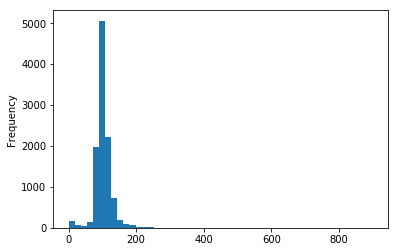

In [8]:
# Analysing runtime

stmdb.runtime.plot.hist(bins=50)
stmdb.loc[stmdb['runtime'] == 0, 'runtime'] = np.nan
stmdb.sort_values(by='runtime', ascending=False).head(5)

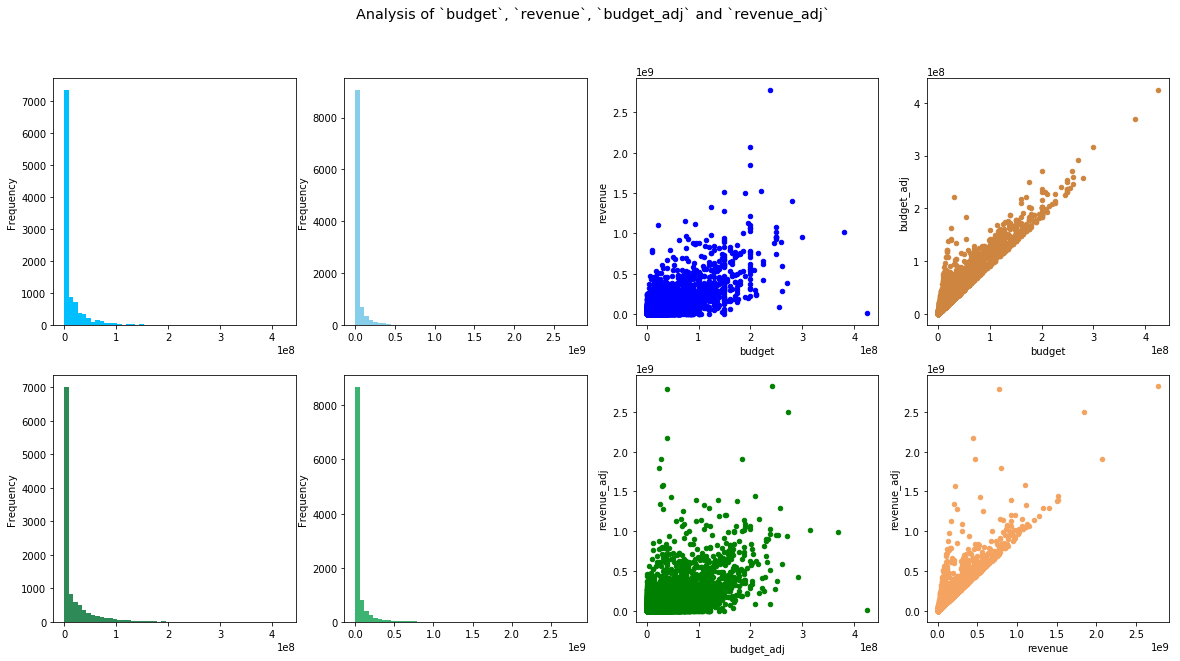

In [9]:
# Analysing `budget`, `revenue`, `budget_adj`, `revenue_adj`

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Analysis of `budget`, `revenue`, `budget_adj` and `revenue_adj`', size='x-large')
# Histograms of `budget`, `revenue`, `budget_adj` and `revenue_adj`
stmdb['budget'].plot.hist(bins=50, ax=ax1, color='deepskyblue')
stmdb['revenue'].plot.hist(bins=50, ax=ax2, color='skyblue')
stmdb['budget_adj'].plot.hist(bins=50, ax=ax5, color='seagreen')
stmdb['revenue_adj'].plot.hist(bins=50, ax=ax6, color='mediumseagreen')
# Scatterplots of 'budget' vs. 'budget_adj' and 'revenue' vs. 'revenue_adj'
stmdb.plot.scatter(x='budget', y='revenue', ax=ax3, color='b')
stmdb.plot.scatter(x='budget_adj', y='revenue_adj', ax=ax7, color='g')
# Scatterplots of 'budget' vs. 'revenue' and 'budget_adj' vs. 'revenue_adj'
stmdb.plot.scatter(x='budget', y='budget_adj', ax=ax4, color='peru')
stmdb.plot.scatter(x='revenue', y='revenue_adj', ax=ax8, color='sandybrown')
plt.show()

In [10]:
# Turning `0` into NaN in `budget`, `revenue`, `budget_adj`and `revenue_adj` as 0 is implausible

stmdb.loc[stmdb['budget'] == 0, 'budget'] = np.nan
stmdb.loc[stmdb['revenue'] == 0, 'revenue'] = np.nan
stmdb.loc[stmdb['budget_adj'] == 0, 'budget_adj'] = np.nan
stmdb.loc[stmdb['revenue_adj'] == 0, 'revenue_adj'] = np.nan
print('\n',
      'Number of mismatches in `Nan` in `budget` and `budget_adj`:\t\t', (stmdb['budget'].isna() != stmdb['budget_adj'].isna()).sum(), '\n',
      'Number of mismatches in `Nan` in `revenue` and `revenue_adj`:\t\t', (stmdb['revenue'].isna() != stmdb['revenue_adj'].isna()).sum(), '\n',
      'Number of mismatches in `Nan` in `budget` and `revenue`:\t\t', (stmdb['budget'].isna() != stmdb['revenue'].isna()).sum(), '\n',
      'Number of mismatches in `Nan` in `budget_adj` and `revenue_adj`:\t', (stmdb['budget_adj'].isna() != stmdb['revenue_adj'].isna()).sum())


 Number of mismatches in `Nan` in `budget` and `budget_adj`:		 0 
 Number of mismatches in `Nan` in `revenue` and `revenue_adj`:		 0 
 Number of mismatches in `Nan` in `budget` and `revenue`:		 2310 
 Number of mismatches in `Nan` in `budget_adj` and `revenue_adj`:	 2310


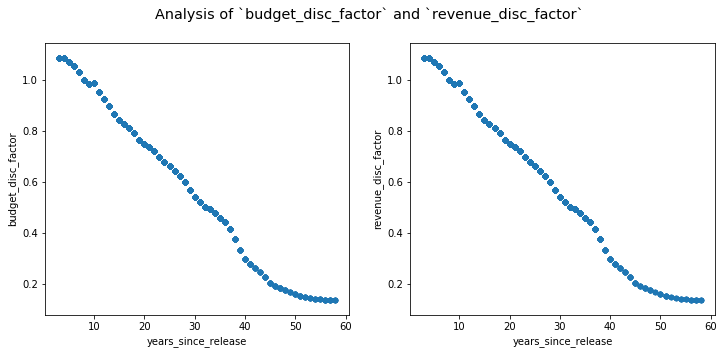

In [11]:
# Analysing discount factors in 'budget_adj' and 'revenue_adj'

discount_factor_df = stmdb[['budget', 'budget_adj', 'revenue', 'revenue_adj']].copy()
discount_factor_df['budget_disc_factor'] = discount_factor_df['budget'] / discount_factor_df['budget_adj']
discount_factor_df['revenue_disc_factor'] = discount_factor_df['revenue'] / discount_factor_df['revenue_adj']
discount_factor_df['years_since_release'] = 2018 - stmdb.release_date.dt.year.copy()

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5))
fig.suptitle('Analysis of `budget_disc_factor` and `revenue_disc_factor`', size='x-large')
discount_factor_df.plot.scatter(x='years_since_release', y='budget_disc_factor', ax=ax1)
discount_factor_df.plot.scatter(x='years_since_release', y='revenue_disc_factor', ax=ax2)

del discount_factor_df

In [12]:
# Calculating 'profit' and 'profit_adj' as new derived feature

stmdb['profit'] = stmdb['revenue'] - stmdb['budget']
stmdb.loc[stmdb['budget'].isna() | stmdb['revenue'].isna(), 'profit'] = np.nan
stmdb['profit_adj'] = stmdb['revenue_adj'] - tmdb['budget_adj']
stmdb.loc[stmdb['budget_adj'].isna() | stmdb['revenue_adj'].isna(), 'profit_adj'] = np.nan

In [13]:
# Shortening and reorganizing columns for further analysis

stmdb = stmdb[
    [
        # Id and title
        'id', 'original_title', 
        # Rating data
        'vote_average',
        # Adjusted economical data
        'budget_adj', 'revenue_adj', 'profit_adj',
        # Release- and run-time
        'release_date', 'runtime', 
        # Genre and content/keywords tags
        'genres', 'keywords', 
        #Companies and people involved
        'production_companies', 'director', 'cast'
    
    ]
]

I want to make use of the information contained in the features that include list-like information (`genres`, `keywords`, `production_companies`, `director` and `cast`).  
In order to do so, I want to separate them in own lists. Then I calculate their quality, based on the `vote_average` of the films where they are connected to. This information shall be used later to combine the films `vote_average` with this quality. But we have to be careful: by calculating it this way, of course we have a correlation. To minimize this factor, we only include such items, that occur minimum e.g. 10 times in different films and thereby smear out the influence (and the correlation) to single films.  
First, we have to write some helper functions:

In [14]:
# Caring for columns with list like entries

# Creating a function to create an expanded dataframe from columns with list-like entries for later analysis
def expand_listlike_column_with_ids_long(df, id_col='', list_col='', pattern=''):
    # Function to create an expanded dataframe from list like entries for later reuse
    expanded = df[[id_col, list_col]].copy()
    expanded[list_col] = df[list_col].str.split(pat=pattern)
    # Borrowed from 'https://mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas-9849d8ff2401'
    expanded = expanded[list_col].apply(pd.Series) \
        .merge(expanded, right_index = True, left_index = True) \
        .drop([list_col], axis = 1) \
        .melt(id_vars = [id_col], value_name = list_col) \
        .drop("variable", axis = 1) \
        .dropna() \
        .drop_duplicates()
    return expanded

In [15]:
def build_sets_from_list(list_col, min_count=10):
    # Customized function to make several trafos and lists for further analysis
        # 'id_with_list_stats' will return a long dictionary of all film ids and list items
        # 'list_stats' will return statistics (averages) of all list items with relation to average votes etc.
        # 'id_with_list_stats' will return statistics (averages) of all id with relation to list stats
        # 'min_count' provides the minimal number of occurances in the list column to provide proper statistics
    
    # Create basic expanded list
    ids_with_list_long = expand_listlike_column_with_ids_long(stmdb, 'id', list_col, '|')
    
    ids_with_list_long_count = pd.DataFrame(
        {
            list_col: ids_with_list_long[list_col].value_counts().index.values, 
            list_col + '_count': ids_with_list_long[list_col].value_counts().values
        }
    )
    ids_with_list_long = pd.merge(ids_with_list_long, ids_with_list_long_count, on=list_col)
    ids_with_list_long = ids_with_list_long.loc[ids_with_list_long[list_col + '_count'] >= min_count]
    
    ids_with_list_long.drop([list_col + '_count'], axis=1, inplace=True)

    # Defined for further focus (main quantitative columns in tmdb)
    _additional_stmdb_info = [
        # focusses on 'vote_average', but could be expanded
        'id',
        'vote_average', #'vote_count', 
        #'budget', 'revenue', 'profit', 
        #'budget_adj', 'revenue_adj', 'profit_adj',
        #'release_date', 'runtime'
    ]
    
    # Intermediate list with info from tmdb
    _list = pd.merge(ids_with_list_long, stmdb[_additional_stmdb_info], on='id', how='left')

    # Statistics on list (with info from tmdb)
    list_stats = _list.groupby(list_col).mean()
    
    # All crammed into one big (intermediate) list
    _list_with_ids_and_stats = pd.merge(_list, list_stats, on=list_col, how='left', suffixes=('', '_' + list_col))
    
    # Stats from genres for ids
    id_with_list_stats = _list_with_ids_and_stats.groupby('id').mean().iloc[:, 1:]
    # if more stats are of interest, iloc needs to be changed
    
    return ids_with_list_long, list_stats, id_with_list_stats

ids_with_genres_long, genres_stats, ids_with_genres_stats = build_sets_from_list('genres')
ids_with_keywords_long, keywords_stats, ids_with_keywords_stats = build_sets_from_list('keywords')
ids_with_prodcos_long, prodcos_stats, ids_with_prodcos_stats = build_sets_from_list('production_companies')
ids_with_directors_long, directors_stats, ids_with_directors_stats = build_sets_from_list('director')
ids_with_actors_long, actors_stats, ids_with_actors_stats = build_sets_from_list('cast')

# Just to see... (1/2)
genres_stats.head(5)

,vote_average
genres,
Action,5.787752
Adventure,5.940585
Animation,6.403147
Comedy,5.905167
Crime,6.124889


In [16]:
# Just to see... (2/2)
ids_with_genres_stats.head(5)

,vote_average_genres
id,
100,6.015028
10001,5.785375
10002,6.111103
10003,5.837493
10004,5.812798


In [17]:
def make_final_stmdb():
    stmdb1 = pd.merge(stmdb, ids_with_genres_stats, on='id', how='left')
    stmdb2 = pd.merge(stmdb1, ids_with_keywords_stats, on='id', how='left')
    stmdb3 = pd.merge(stmdb2, ids_with_prodcos_stats, on='id', how='left')
    stmdb4 = pd.merge(stmdb3, ids_with_directors_stats, on='id', how='left')
    stmdb_final = pd.merge(stmdb4, ids_with_actors_stats, on='id', how='left')
    return stmdb_final

atmdb = make_final_stmdb()

In [18]:
create_overview(atmdb)

,example,dtype,count,complete_%,unique_alt,top_alt,freq_alt,mean,std,min,median,max
id,135397,object,10865,100,10865,244001,1,NaN,NaN,NaN,NaN,NaN
original_title,Jurassic World,object,10865,100,10571,Hamlet,4,NaN,NaN,NaN,NaN,NaN
vote_average,6.5,float64,10865,100,72,6.1,496,5.97501,0.935138,1.5,6,9.2
budget_adj,1.38e+08,float64,5169,47.5748,2613,10164004.3412495,17,3.68891e+07,4.1961e+07,0.921091,2.27151e+07,4.25e+08
revenue_adj,1.39245e+09,float64,4849,44.6295,4839,57667591.0300945,2,1.15101e+08,1.98856e+08,2.37071,4.39567e+07,2.82712e+09
profit_adj,1.25445e+09,float64,3854,35.4717,3851,0.0,4,9.28247e+07,1.94071e+08,-4.13912e+08,2.73706e+07,2.75014e+09
release_date,2015-06-09 00:00:00,datetime64[ns],10865,100,5909,2009-01-01 00:00:00,28,NaN,NaN,NaN,NaN,NaN
runtime,124,float64,10834,99.7147,246,90.0,547,102.364,30.9482,2,99,900
genres,Action|Adventure|Science Fiction|Thriller,object,10842,99.7883,2039,Comedy,712,NaN,NaN,NaN,NaN,NaN
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,object,9372,86.2586,8804,woman director,134,NaN,NaN,NaN,NaN,NaN


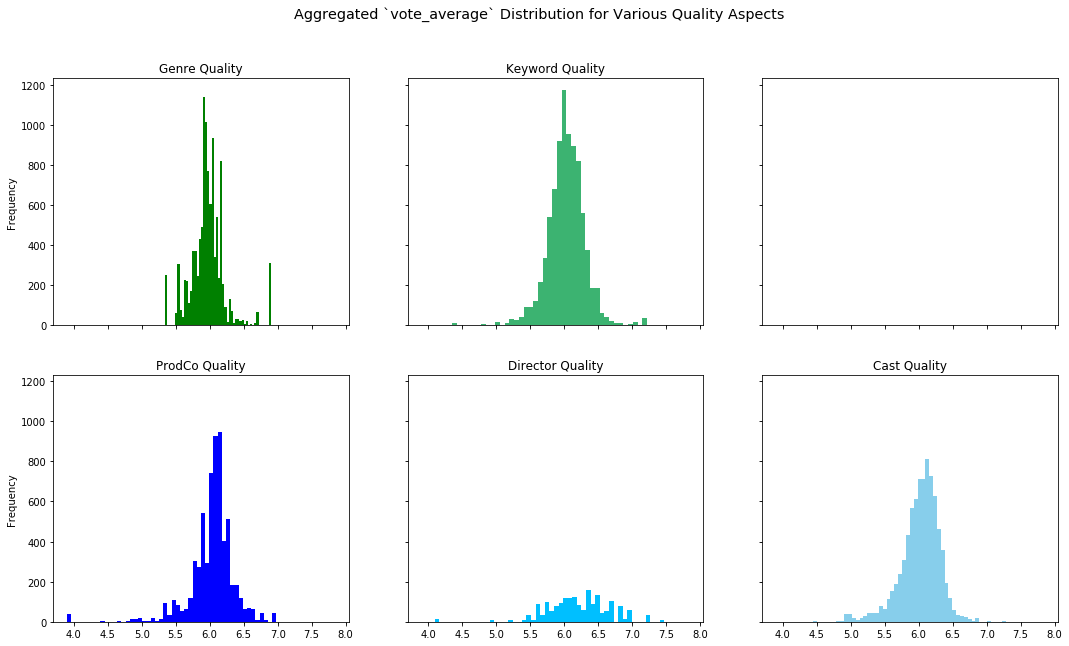

In [19]:
# Inspect the new features

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(18,10))
fig.suptitle('Aggregated `vote_average` Distribution for Various Quality Aspects' , size='x-large')
atmdb['vote_average_genres'].plot.hist(bins=50, ax=ax1, title='Genre Quality', color='g')
atmdb['vote_average_keywords'].plot.hist(bins=50, ax=ax2, title='Keyword Quality', color='mediumseagreen')
atmdb['vote_average_production_companies'].plot.hist(bins=50, ax=ax4, title='ProdCo Quality', color='b')
atmdb['vote_average_director'].plot.hist(bins=50, ax=ax5, title='Director Quality', color='deepskyblue')
atmdb['vote_average_cast'].plot.hist(bins=50, ax=ax6, title='Cast Quality', color='skyblue')
plt.show()

<a id="analysis"></a>
# Analysis of Initial Questions

## How Are Economics Factors Related to `vote_average`?

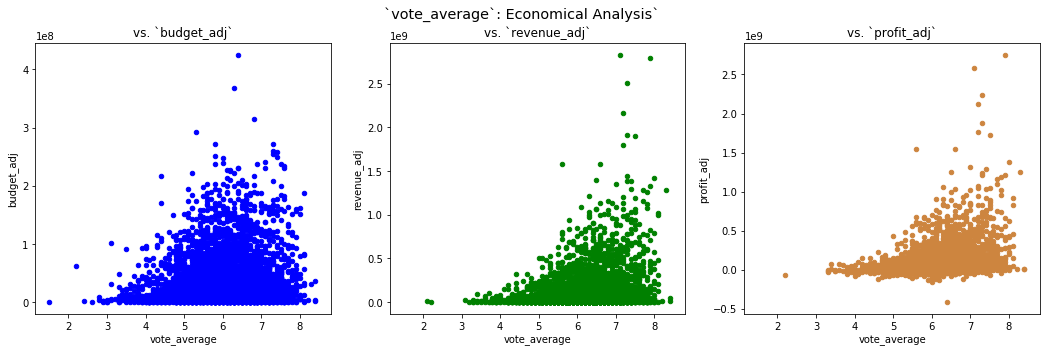

In [20]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
fig.suptitle('`vote_average`: Economical Analysis`', size='x-large')
atmdb.plot.scatter(x='vote_average', y='budget_adj', ax=ax1, title='vs. `budget_adj`', color='b')
atmdb.plot.scatter(x='vote_average', y='revenue_adj', ax=ax2, title='vs. `revenue_adj`', color='g')
atmdb.plot.scatter(x='vote_average', y='profit_adj', ax=ax3, title='vs. `profit_adj`', color='peru')
plt.show()

In [21]:
atmdb[['budget_adj', 'revenue_adj', 'profit_adj']].corrwith(atmdb.vote_average)

budget_adj     0.112226
revenue_adj    0.242319
profit_adj     0.288651
dtype: float64

As one can see, economical factors are only weakly correlated to film quality in terms of `vote_average`.  
Especially budget is only very weakly correlated: it's possible to make a "bad" film with lots of money, and pretty good films with a comparably small budget.
On the other hand, it happens that "good" films make fantastic profits (*yay!*), but you can also make a nice film, and lose a lot on it.

In [22]:
atmdb[atmdb.profit_adj == atmdb.profit_adj.min()].T

,2243
id,46528
original_title,The Warrior's Way
vote_average,6.4
budget_adj,4.25e+08
revenue_adj,1.10876e+07
profit_adj,-4.13912e+08
release_date,2010-12-02 00:00:00
runtime,100
genres,Adventure|Fantasy|Action|Western|Thriller
keywords,assassin|small town|revenge|deception|super speed


In [23]:
atmdb[atmdb.profit_adj == atmdb.profit_adj.max()].T

,1329
id,11
original_title,Star Wars
vote_average,7.9
budget_adj,3.95756e+07
revenue_adj,2.78971e+09
profit_adj,2.75014e+09
release_date,1977-03-20 00:00:00
runtime,121
genres,Adventure|Action|Science Fiction
keywords,android|galaxy|hermit|death star|lightsaber


### How is "Ingredient" Quality Related to Film Quality?

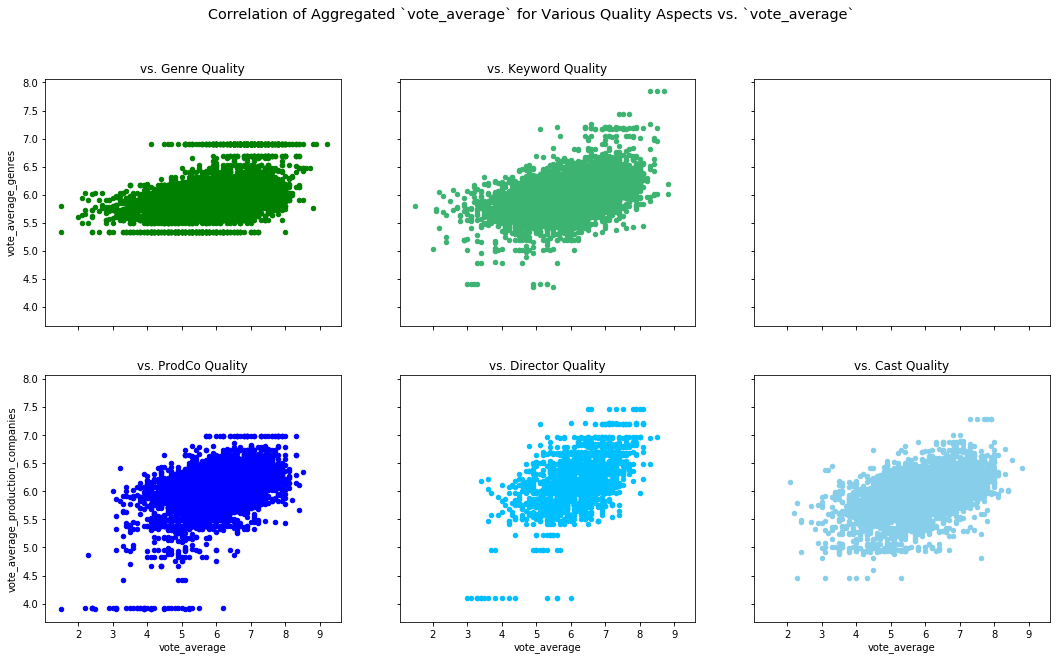

In [24]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(18,10))
fig.suptitle('Correlation of Aggregated `vote_average` for Various Quality Aspects vs. `vote_average`' , size='x-large')
atmdb.plot.scatter(x='vote_average', y='vote_average_genres', ax=ax1, title='vs. Genre Quality', color='g')
atmdb.plot.scatter(x='vote_average', y='vote_average_keywords', ax=ax2, title='vs. Keyword Quality', color='mediumseagreen')
atmdb.plot.scatter(x='vote_average', y='vote_average_production_companies', ax=ax4, title='vs. ProdCo Quality', color='b')
atmdb.plot.scatter(x='vote_average', y='vote_average_director', ax=ax5, title='vs. Director Quality', color='deepskyblue')
atmdb.plot.scatter(x='vote_average', y='vote_average_cast', ax=ax6, title='vs. Cast Quality', color='skyblue')
plt.show()

In [25]:
atmdb[['vote_average_genres', 'vote_average_keywords', 'vote_average_production_companies', 'vote_average_director', 'vote_average_cast']].corrwith(atmdb.vote_average)

vote_average_genres                  0.417699
vote_average_keywords                0.445270
vote_average_production_companies    0.452206
vote_average_director                0.570411
vote_average_cast                    0.500771
dtype: float64

There is a medium correlation of quality of the various "ingredients" to the `vote_average` of the films. As the definition of the quality of the ingredients is based on the `vote_average`, it's hard to tell, how strong the influence of the feedback is. This should be further investigated.  
However, it seems - and this corresponds with my intuition - that the quality of a film is based on the quality of its components.

In [26]:
genres_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
genres,
Documentary,6.908462
Music,6.480392
History,6.410479
Animation,6.403147
War,6.297778


In [27]:
genres_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
genres,
TV Movie,5.788024
Action,5.787752
Thriller,5.750671
Science Fiction,5.665582
Horror,5.337447


In [28]:
keywords_stats.sort_values(by='vote_average', ascending=False).head()

,vote_average
keywords,
live concert,7.850000
stand-up,7.207895
stand up comedy,7.163889
pixar animated short,7.039130
concert,7.015789


In [29]:
keywords_stats.sort_values(by='vote_average', ascending=False).tail()

,vote_average
keywords,
alien invasion,4.980000
bikini,4.890000
possession,4.783333
based on video game,4.409524
shark,4.353846


In [30]:
prodcos_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
production_companies,
Heyday Films,7.066667
Pixar Animation Studios,6.980769
WingNut Films,6.980000
BBC,6.976923
Bad Robot,6.830000


In [31]:
prodcos_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
production_companies,
Steamroller Productions,4.763636
Castel Film Romania,4.661538
Hollywood Media Bridge,4.416667
The Asylum,3.925806
"Asylum, The",3.900000


In [32]:
directors_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
director,
Christopher Nolan,7.470000
David Fincher,7.210000
Quentin Tarantino,7.207143
Wes Anderson,7.200000
Martin Scorsese,6.970968


In [33]:
directors_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
director,
Tobe Hooper,5.471429
Paul Hoen,5.410000
Brian Levant,5.230000
Stuart Gillard,4.954545
Uwe Boll,4.093750


In [34]:
actors_stats.sort_values(by='vote_average', ascending=False).head(5)

,vote_average
cast,
Louis C.K.,7.290000
Kevin Conroy,7.007692
Benedict Cumberbatch,6.892308
Paul McCartney,6.880000
Daniel Radcliffe,6.875000


In [35]:
actors_stats.sort_values(by='vote_average', ascending=False).tail(5)

,vote_average
cast,
Danny Trejo,4.910345
Bruce Payne,4.880000
Dominic Purcell,4.811765
Tara Reid,4.600000
Casper Van Dien,4.450000
